# Delivery of grocery orders report - Data analysis and visualisation

First, I had to explore and clean the data.

# Data exploration and cleaning

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [3]:
prediction_errors_df = pd.read_csv('prediction_errors.csv')
orders = pd.read_csv('orders.csv', sep=';')
route_segments = pd.read_csv('route_segments.csv',sep=";")


I started with sorting the data contained in route_segments by drivers and time. First thing I realized was lack of assignment of order_id to parts of the route marked as "DRIVE". There were also "STOPS" without order_id, probably corresponding to breaks or stops at petrol station. It might elso be erronous data so I decided to remove it.

In [4]:
route_segments = route_segments.sort_values(by=["driver_id", "segment_start_time", "segment_end_time"])
route_segments['driver_id'].unique()
for driver_id in route_segments['driver_id'].unique():
    df=route_segments[route_segments['driver_id']==driver_id]
   

In [5]:
df.head(20)

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time
227,227,4,DRIVE,0,2024-02-01 02:15:25,2024-02-01 02:20:48
226,226,4,STOP,255,2024-02-01 02:23:48,2024-02-01 02:27:19
39,39,4,DRIVE,0,2024-02-01 02:43:01,2024-02-01 02:47:54
38,38,4,STOP,1325,2024-02-01 02:50:54,2024-02-01 03:00:10
4180,4180,4,DRIVE,0,2024-02-01 03:04:17,2024-02-01 03:08:57
4179,4179,4,STOP,1447,2024-02-01 03:11:57,2024-02-01 03:21:16
4012,4012,4,DRIVE,0,2024-02-01 05:35:28,2024-02-01 05:40:41
4011,4011,4,STOP,2223,2024-02-01 05:43:41,2024-02-01 05:47:30
4941,4941,4,DRIVE,0,2024-02-01 06:06:15,2024-02-01 06:10:31
1898,1898,4,DRIVE,0,2024-02-01 06:10:50,2024-02-01 06:17:01


Table 1. Sample of data contained in route_segments

In [6]:
# remove STOP segments where order_id is 0
route_segments = route_segments[~((route_segments['segment_type'] == 'STOP') & (route_segments['order_id'] == 0))]


There were also entries with consecutive "DRIVE" type, separated only by a short (under a minute) breaks so I decided to merge them (see segments 4941 and 1898 in Table 1). Furthermore there was overlapping of some segments, such that "STOPS" appeared in the middle of "DRIVES" (e.g. segments 1898 and 4940). For this I had to adjust times of "DRIVES" so they would end where next "STOP" started and create new "DRIVE" segments starting when "STOPs" end and ending when the original DRIVE was supposed to end. The last step was to finally assign order_id to "DRIVEs" from consecutive "STOPs".

In [7]:
def merge_consecutive_drives(df):
    # sort by driver_id and segment_start_time first
    df = df.sort_values(by=['driver_id', 'segment_start_time'])
    
    merged_rows = []
    previous_row = None
    for index, row in df.iterrows():
        if previous_row is not None and row['segment_type'] == 'DRIVE' and previous_row['segment_type'] == 'DRIVE':
            # extend the previous DRIVE segment's end_time to the current row's end_time
            previous_row['segment_end_time'] = row['segment_end_time']
        else:
            if previous_row is not None:
                merged_rows.append(previous_row)
            previous_row = row
    if previous_row is not None:
        merged_rows.append(previous_row)  # add the last row
    
    return pd.DataFrame(merged_rows)

route_segments = merge_consecutive_drives(route_segments)
route_segments.head(20)
for driver_id in route_segments['driver_id'].unique():
    df=route_segments[route_segments['driver_id']==driver_id]
    


In [8]:
def adjust_drive_segments(df):
    # initialize an empty list to store the adjusted segments
    adjusted_segments = []
    skip_next = False
    # iterate through the sorted DataFrame
    for i, (_, row) in enumerate(df.iterrows()):
        
        # if the segment is a DRIVE and overlaps with the next STOP segment
        if i < len(df) - 1:  # ensure we don't go out of bounds
            next_row = df.iloc[i + 1]
            
            if row['segment_type'] == 'DRIVE' and next_row['segment_type'] == 'STOP' and row['segment_end_time'] > next_row['segment_start_time']:
                # adjust the current DRIVE to end when the STOP starts
                adjusted_drive = row.copy()
                adjusted_drive['segment_end_time'] = next_row['segment_start_time']
                adjusted_segments.append(adjusted_drive.to_dict())
                
                # insert the STOP segment
                adjusted_segments.append(next_row.to_dict())
                
                # create a new DRIVE segment starting when the STOP ends and ending when the original DRIVE was supposed to end
                new_drive = row.copy()
                new_drive["segment_id"] = None
                new_drive['segment_start_time'] = next_row['segment_end_time']
                adjusted_segments.append(new_drive.to_dict())
                skip_next = True
            elif skip_next:
                skip_next = False
            else:
                adjusted_segments.append(row.to_dict())
                
    
    # create a DataFrame from the adjusted segments
    adjusted_df = pd.DataFrame(adjusted_segments)
    
    return adjusted_df


route_segments = adjust_drive_segments(route_segments)

route_segments.head(20)

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time
0,879.0,1,DRIVE,0,2024-02-01 02:08:40,2024-02-01 02:11:36
1,878.0,1,STOP,1053,2024-02-01 02:14:36,2024-02-01 02:15:41
2,698.0,1,DRIVE,0,2024-02-01 02:56:02,2024-02-01 03:02:51
3,697.0,1,STOP,2138,2024-02-01 03:02:51,2024-02-01 03:03:35
4,NaN,1,DRIVE,0,2024-02-01 03:03:35,2024-02-01 03:10:12
5,3199.0,1,STOP,1244,2024-02-01 03:13:12,2024-02-01 03:14:35
6,2808.0,1,DRIVE,0,2024-02-01 03:23:13,2024-02-01 03:34:49
7,2807.0,1,STOP,64,2024-02-01 03:34:49,2024-02-01 03:35:35
8,NaN,1,DRIVE,0,2024-02-01 03:35:35,2024-02-01 03:43:53
9,3796.0,1,STOP,455,2024-02-01 03:46:53,2024-02-01 03:48:06


In [9]:
# Assigning adjacent order_id to values with segment_type "DRIVE"
route_segments.loc[route_segments['order_id'] == 0, "order_id"] = None
route_segments["order_id"] = route_segments.groupby('driver_id')['order_id'].transform(lambda x: x.bfill())
route_segments.head(20)

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time
0,879.0,1,DRIVE,1053.0,2024-02-01 02:08:40,2024-02-01 02:11:36
1,878.0,1,STOP,1053.0,2024-02-01 02:14:36,2024-02-01 02:15:41
2,698.0,1,DRIVE,2138.0,2024-02-01 02:56:02,2024-02-01 03:02:51
3,697.0,1,STOP,2138.0,2024-02-01 03:02:51,2024-02-01 03:03:35
4,NaN,1,DRIVE,1244.0,2024-02-01 03:03:35,2024-02-01 03:10:12
5,3199.0,1,STOP,1244.0,2024-02-01 03:13:12,2024-02-01 03:14:35
6,2808.0,1,DRIVE,64.0,2024-02-01 03:23:13,2024-02-01 03:34:49
7,2807.0,1,STOP,64.0,2024-02-01 03:34:49,2024-02-01 03:35:35
8,NaN,1,DRIVE,455.0,2024-02-01 03:35:35,2024-02-01 03:43:53
9,3796.0,1,STOP,455.0,2024-02-01 03:46:53,2024-02-01 03:48:06


Table 2. "DRIVEs" with id_orders assigned from corresponding "STOPS"

# Part 1 - Calculating the actual delivery length

Having prepared the data, I could start with the task of calculating the actual length of provided delivieries. First, I had to calculate duration of specific segments and then sum corresponding "DRIVEs" and "STOPs" for each order_id. Additionally I filtered obtained durations to exlude potential values below 0 (due to incorrect data) and outliers exceeding 200 minutes, which could skew the results (initial basic analysis showed a group of values around 240, suggesting some errors with data collection, normally they should be distributed more randomly). While preparing histogram I filtered data again to include values up to 0.99 percentile. Exluded values were probably correct (maybe due to some random situation, such as traffic accident), but made the chart highly illegible.

In [10]:
# convert start and end times to datetime format
route_segments['segment_start_time'] = pd.to_datetime(route_segments['segment_start_time'])
route_segments['segment_end_time'] = pd.to_datetime(route_segments['segment_end_time'])

# calculate segment durations in minutes
route_segments['segment_duration_minutes'] = (route_segments['segment_end_time'] - route_segments['segment_start_time']).dt.total_seconds() / 60
route_segments

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time,segment_duration_minutes
0,879.0,1,DRIVE,1053.0,2024-02-01 02:08:40,2024-02-01 02:11:36,2.933333
1,878.0,1,STOP,1053.0,2024-02-01 02:14:36,2024-02-01 02:15:41,1.083333
2,698.0,1,DRIVE,2138.0,2024-02-01 02:56:02,2024-02-01 03:02:51,6.816667
3,697.0,1,STOP,2138.0,2024-02-01 03:02:51,2024-02-01 03:03:35,0.733333
4,NaN,1,DRIVE,1244.0,2024-02-01 03:03:35,2024-02-01 03:10:12,6.616667
...,...,...,...,...,...,...,...
4376,1011.0,4,STOP,9.0,2024-02-28 19:40:37,2024-02-28 19:43:48,3.183333
4377,3824.0,4,STOP,1119.0,2024-02-28 19:44:09,2024-02-28 19:46:41,2.533333
4378,383.0,4,DRIVE,1426.0,2024-02-28 21:06:27,2024-02-28 21:15:22,8.916667
4379,382.0,4,STOP,1426.0,2024-02-28 21:15:22,2024-02-28 21:17:34,2.200000


Table 3. Sample of route_segments with calculated duration of each segment (in minutes)

In [11]:
# aggregate the total duration of DRIVE and STOP segments for each order_id
order_delivery_durations = route_segments.groupby('order_id')['segment_duration_minutes'].sum().reset_index(name='total_delivery_length_minutes')

# filter order_delivery_durations for total_delivery_length_minutes > 0 and <= 200
order_delivery_durations = order_delivery_durations[(order_delivery_durations['total_delivery_length_minutes'] > 0) & 
                                                    (order_delivery_durations['total_delivery_length_minutes'] <= 200)]

order_delivery_durations.head(20)


,order_id,total_delivery_length_minutes
0,1.0,2.733333
2,3.0,7.833333
3,4.0,1.350000
4,5.0,11.683333
5,6.0,0.716667
7,8.0,9.150000
8,9.0,11.016667
9,10.0,8.183333
10,11.0,5.600000
11,12.0,14.400000


Table 4. Orders with their corresponding delivery lengths (aggregating "DRIVEs" and "STOPs")

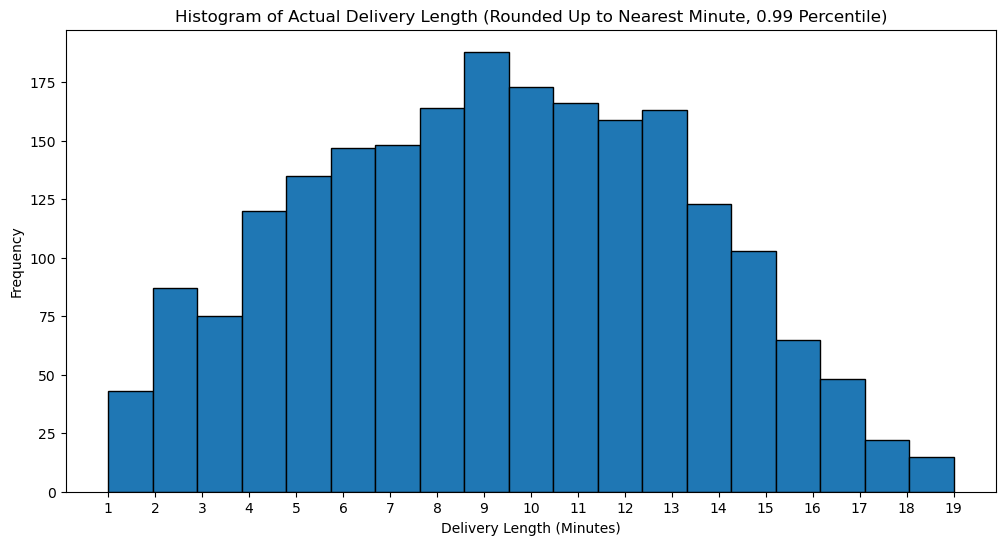

In [12]:
# calculate the 0.99 percentile of the total_delivery_length_minutes
percentile_99 = order_delivery_durations['total_delivery_length_minutes'].quantile(0.99)

# filter the DataFrame to only include rows with delivery lengths up to the 0.99 percentile
order_delivery_durations = order_delivery_durations[order_delivery_durations['total_delivery_length_minutes'] <= percentile_99]

# round up the total_delivery_length_minutes to the nearest whole number for the filtered DataFrame
order_delivery_durations['rounded_delivery_length'] = np.ceil(order_delivery_durations['total_delivery_length_minutes'])

# generate the histogram for the filtered and rounded delivery lengths
plt.figure(figsize=(12, 6))
plt.hist(order_delivery_durations['rounded_delivery_length'], bins=int(order_delivery_durations['rounded_delivery_length'].max()), edgecolor='black')
plt.title('Histogram of Actual Delivery Length (Rounded Up to Nearest Minute, 0.99 Percentile)')
plt.xlabel('Delivery Length (Minutes)')
plt.ylabel('Frequency')

# set x-axis ticks to reflect each minute up to the max rounded delivery length in the filtered data
plt.xticks(np.arange(1, order_delivery_durations['rounded_delivery_length'].max() + 1, 1.0))

plt.show()



Fig. 1. Histogram showing the distribution of actual delivery durations (rounded up to 1 minute)

# Part 2 - Predictions

Next step was to compare actual and planned delivery times. The latter were provided in "orders" and extracted to "prediction_errors_df" using MySQL Workbench. To execute the task I first had to merge "prediction_errors_df" with "order_delivery_durations" (see Table 5) and then calculate the prediction error by substracting planned and actual delivery durations. Finally I created a histogram showing obtained values (fig. 2).

In [13]:
# merging the DataFrames on 'order_id'
merged_df = pd.merge(prediction_errors_df, order_delivery_durations[['order_id', 'total_delivery_length_minutes']], on='order_id')

# calculate prediction error
merged_df['prediction_error_minutes'] = merged_df['planned_delivery_duration'] - merged_df['total_delivery_length_minutes']
merged_df.head()

,order_id,planned_delivery_duration,prediction_error_minutes,total_delivery_length_minutes
0,1,169,166.266667,2.733333
1,3,176,168.166667,7.833333
2,4,177,175.650000,1.350000
3,5,176,164.316667,11.683333
4,6,177,176.283333,0.716667


Table 5. Effect of merging "prediction_errors_df" with "order_delivery_durations"

C:\Users\Grazyna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


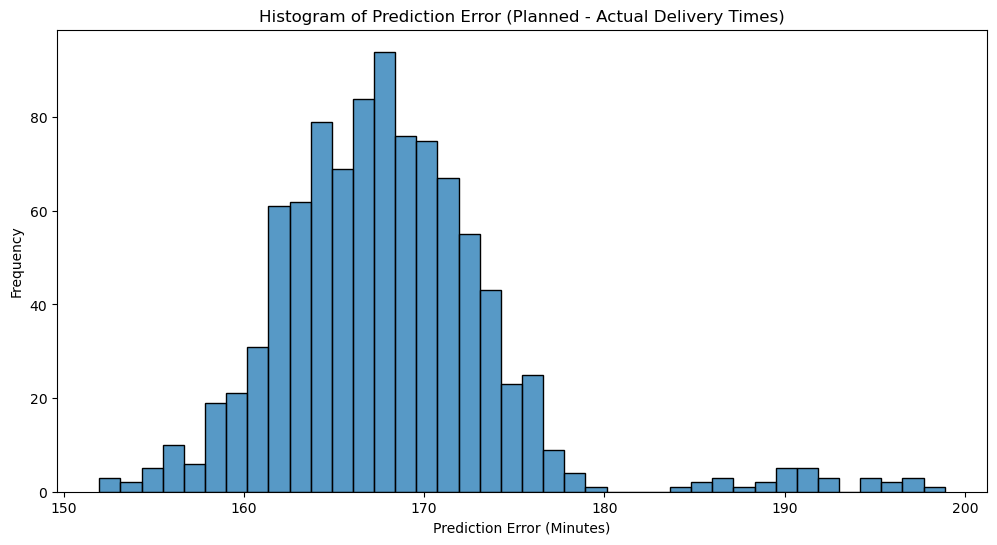

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the histogram for prediction errors
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['prediction_error_minutes'], bins=40, kde=False, edgecolor='black')
plt.title('Histogram of Prediction Error (Planned - Actual Delivery Times)')
plt.xlabel('Prediction Error (Minutes)')
plt.ylabel('Frequency')
plt.show()


FIg. 2. Histogram showing the prediction error delivery times

As we can see above, the prediction error is very large. Planned durations are much longer than most actual ones, making the predictions quite useless.

# Part 3 - Sectors hypothesis

Next we had to check the hypothesis that delivering in one of the sectors is
significantly longer than in other sectors. To do that I first merged "orders" with "order_delivery_durations" (Table 6). Next I calculated average delivery durations for each sector and presented them on histogram (fig. 3)

In [15]:
# merge the orders DataFrame with the order_delivery_durations DataFrame on order_id
merged_data = pd.merge(orders[['order_id', 'sector_id']], 
                       order_delivery_durations[['order_id', 'total_delivery_length_minutes']],
                       on='order_id')
merged_data

,order_id,sector_id,total_delivery_length_minutes
0,1,1,2.733333
1,3,3,7.833333
2,4,2,1.350000
3,5,2,11.683333
4,6,2,0.716667
...,...,...,...
2139,2235,3,9.566667
2140,2236,1,11.716667
2141,2237,2,10.950000
2142,2238,1,4.750000


Table 6. Effect of merging "orders" and "order_delivery_duration"

In [18]:
# aggregate the total delivery length by sector_id, calculating the mean delivery length for each sector
sector_delivery_lengths = merged_data.groupby('sector_id')['total_delivery_length_minutes'].mean().reset_index()
sector_delivery_lengths.rename(columns={'total_delivery_length_minutes': 'mean_delivery_time'}, inplace=True)

sector_delivery_lengths

,sector_id,mean_delivery_time
0,1,9.571048
1,2,8.384734
2,3,8.495912


Table 7. Average delivery times for each sector

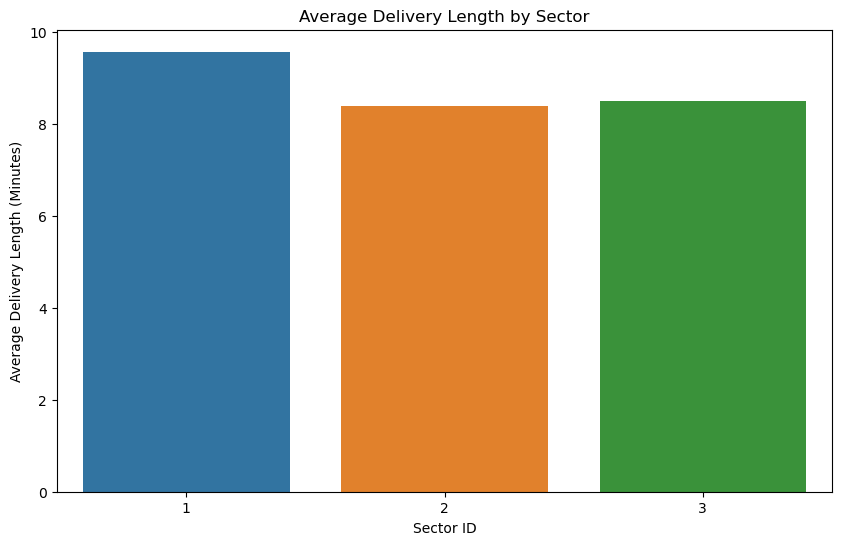

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(data=sector_delivery_lengths, x='sector_id', y='mean_delivery_time')
plt.title('Average Delivery Length by Sector')
plt.xlabel('Sector ID')
plt.ylabel('Average Delivery Length (Minutes)')

plt.show()

Fig. 3. Histogram showing average delivery times for specific sectors